# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# %pip install -U missingno

In [42]:
%%time
from plugins.plugin_utils import *
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from IPython.core.magic import (Magics, magics_class, line_magic, cell_magic)
from IPython import get_ipython
from datetime import datetime
%matplotlib inline

conn = prepare_connection(sqlite3.connect('starbucks.db', detect_types=sqlite3.PARSE_DECLTYPES))
@magics_class
class SqlMagic(Magics):

    @cell_magic
    def sql(self, line, cell):
        return conn.execute(cell).fetchall()

    @cell_magic
    def to_df(self, line, cell):
        return pd.read_sql(cell, conn)
    
get_ipython().register_magics(SqlMagic)    
sql = lambda x: conn.execute(x).fetchall()
to_df = lambda x: pd.read_sql(x, conn)
# read in the json files
# portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
# profile = pd.read_json('data/profile.json', orient='records', lines=True)
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

CPU times: user 2.31 ms, sys: 1.5 ms, total: 3.81 ms
Wall time: 3.91 ms


In [43]:
%%time
pd.read_json('data/portfolio.json', orient='records', lines=True).to_sql('portfolio', 
                                                                         conn,
                                                                         index=False, 
                                                                         if_exists='replace') 
pd.read_json('data/profile.json', orient='records', lines=True).to_sql('profile',
                                                                       conn,
                                                                       index=False,
                                                                       if_exists='replace') 
pd.read_json('data/transcript.json', orient='records', lines=True).to_sql('transcript',
                                                                          conn,
                                                                          index=False,
                                                                          if_exists='replace') 

CPU times: user 4.21 s, sys: 311 ms, total: 4.52 s
Wall time: 4.57 s


In [44]:
%%time
def clean_transcripts():
    offers = to_df(
        """select person,
               event,
               json_extract(value, '$.offer_id') offer_id,
               json_extract(value, '$.reward')   reward,
               time
        from (
                 select person, event, replace(value, 'offer id', 'offer_id') value, time
                 from transcript
                 where event like '%offer%'
             );""")
    transactions = to_df("""select person, 
                               -- event, 
                               json_extract(value, '$.amount') amount, time
                            from transcript
                            where event not like '%offer%';""")
    return offers, transactions
offers, transactions = clean_transcripts()

CPU times: user 889 ms, sys: 34.7 ms, total: 924 ms
Wall time: 924 ms


In [47]:
def clean_profile():
#     profile = df.copy()
    profile = to_df('select * from profile')
    profile.age = profile.age.astype(int)
    
    #CONVERT GENDER TO CATEGORY
#     profile = pd.concat([profile, pd.get_dummies(profile.gender, prefix='gender_')]).drop(columns=['gender'])
    profile.gender = profile.gender.astype('category')
    
    #CLEAN DATE FIELD
    conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN
    profile.became_member_on = profile.became_member_on.apply(conv_date).astype('datetime64')
    profile = profile[profile.age != 118]
    
    #BINNING AGE BRACKETS
    mapping = [profile['age'].between(0, 22), 
                profile['age'].between(23, 38),
                profile['age'].between(39, 54),
                profile['age'].between(55, 73),
                profile['age'].between(74, 150),]
    vals = ['gen_z', 'millenial', 'gen_x', 'ok_boomer', 'silent_gen']
    profile['age_bracket'] = np.select(mapping, vals, 0)
    
    profile.income = profile.income.astype(int)
    return profile

profile = clean_profile()
profile.sample(5)

,gender,age,id,became_member_on,income,age_bracket
1512,M,35,b6f831aeda5f4183ab523e07e1eff7f7,2017-09-06,42000,millenial
4663,F,78,455a7c0dc2cc41b1a30c8722fc8b4c39,2016-12-02,74000,silent_gen
3000,F,64,5291d2e620fa4733834501c8ad5df4c2,2018-01-19,79000,ok_boomer
14680,M,54,211c1b601543428198d735c2526e6225,2015-08-07,46000,gen_x
10467,M,57,8807861d85f24d7c8d888f33e96d940e,2016-06-30,79000,ok_boomer


In [49]:
def clean_portfolio():
    portfolio = to_df('select * from portfolio')
    portfolio.channels = portfolio.channels.apply(json.loads)
    portfolio.channels = portfolio.channels.apply(lambda x: sorted(x))
    'Example adapted from: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies'
    _ = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio[list(_)] = _
    portfolio = portfolio.drop(columns=['channels'])
    portfolio.offer_type = portfolio.offer_type.astype('category')
    return portfolio

# portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio = clean_portfolio()
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


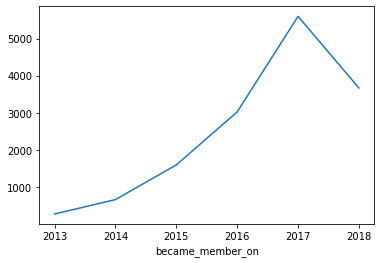

In [50]:
profile.groupby(profile.became_member_on.dt.year).count()['age'].plot()

In [52]:
# for c in list(transcript):
#     print(transcript.isnull().sum())
print('Total rows:', len(profile), len(offers), len(transactions))
sep = '\n'+'*'*60 + '\n'
# print(f'{sep}Transcript % NULLs:{sep}{transcript.isnull().sum()/len(transcript)}')
print(f'{sep}Offers % NULLs:{sep}{offers.isnull().sum()/len(offers)}')
print(f'{sep}Transactions % NULLs:{sep}{transactions.isnull().sum()/len(transactions)}')
print(f'{sep}Profile % NULLs:{sep}{profile.isnull().sum()/len(profile)}')
# print(f'{sep}Portfolio % NULLs:{sep}{portfolio.isnull().sum()/len(portfolio)}')

Total rows: 14825 167581 138953

************************************************************
Offers % NULLs:
************************************************************
person      0.000000
event       0.000000
offer_id    0.000000
reward      0.799625
time        0.000000
dtype: float64

************************************************************
Transactions % NULLs:
************************************************************
person    0.0
amount    0.0
time      0.0
dtype: float64

************************************************************
Profile % NULLs:
************************************************************
gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
age_bracket         0.0
dtype: float64


In [29]:
profile.sample(10)

,gender,age,id,became_member_on,income,age_bracket
10246,M,56,773bec02e0ce497ca404dff3e236c9f7,2016-10-13,36000,ok_boomer
6479,F,75,ba79df515e71410bb0f60eb9fd00e83d,2016-06-05,66000,silent_gen
10282,M,46,e4989ca3d8974e28a3fe87aa0b0ce327,2018-07-26,74000,gen_x
4882,M,53,3971f0bafa78424ea2361204747cb108,2013-12-12,53000,gen_x
10469,M,50,476bce5ff4194f9cafa2bb4aad0d9ad1,2018-04-25,66000,gen_x
1058,F,49,a637ef4f38a8419ca56c6903c6f2657c,2017-12-27,54000,gen_x
2972,M,60,ee9513c6c8a3410e921d70e8522b0e2b,2017-12-17,46000,ok_boomer
12014,M,21,6f6778a3d3ac40b1bc13893c226a3f97,2016-02-13,73000,gen_z
9344,M,36,9e2ba3d151564f86900754e6036febba,2016-03-07,72000,millenial
6893,F,89,4b54746836c34bc9a0db105b7d144de8,2017-10-16,38000,silent_gen


In [53]:
transactions.to_sql('transactions', conn, index=False, if_exists='replace') 
offers.to_sql('offers', conn, index=False, if_exists='replace') 
portfolio.to_sql('portfolio', conn, index=False, if_exists='replace') 
profile.to_sql('profile', conn, index=False, if_exists='replace') 


In [55]:
%%sql 
create index if not exists offers_offer_id_idx on offers(offer_id);

[]